# MNIST Perceptron Network
#Brady Young

  For this assignment I created multiple perceptron networks to identify handwritten numbers. The networks consisted of a feature array to hold the input values, an array of weights used to calculate the output of a node, and ten output nodes corresponding to each of the ten digits. The goal of the network is to manipulate the weight values such that the output error of the network is minimized. This is accomplished by feeding a set of features through the network, calculating the output of each node, identifying the error for each node, and propogating the error back through the network, adjusting the weights in the direction of the target output for that node.
  Each network incorporated a different learning rate to observe the relation between a network's learning rate and the accuracy of its outputs as training progressed. The rates implemented and observed were (0.0001, 0.001, 0.01, 0.1, 1).

## Modules

In [0]:
import numpy as np     #Used for array operations
import time            #Used to benchmark training
import csv             #Used for import dataset
import requests        #Used to download dataset
import sys             #Used to format printing
import os              #Used to manage filesystem
import pandas

## Preprocessing and Data Acquistion

###System

In [0]:
#Creates directory for writing data files
if(os.path.isdir('data') == False):
  os.makedirs('data')

###Remote Files

In [0]:
#Writes both training dataset and test dataset from
#remote location to local files

if(os.path.isfile('data/mnist_train.csv') == False):
  link = 'http://web.cecs.pdx.edu/~mm/MachineLearningWinter2019/mnist_train.csv'
  r = requests.get(link)
  with open('data/mnist_train.csv', 'wb') as file:
    file.write(r.content)
  
  link = 'http://web.cecs.pdx.edu/~mm/MachineLearningWinter2019/mnist_test.csv'
  r = requests.get(link)
  with open('data/mnist_test.csv', 'wb') as file:
      file.write(r.content)

### Reading in Data

In [0]:
#Copies the MNIST data into memory
trainset_in = []
testset_in =[]

with open('data/mnist_train.csv', mode='r') as file:
  reader = csv.reader(file)
  for row in reader:
    trainset_in.append(row)
                
with open('data/mnist_test.csv', mode='r') as file:
  reader = csv.reader(file)
  for row in reader:
    testset_in.append(row)

### Dataset

In [0]:
#A wrapper to process the dataset after reading
class Dataset:
  def __init__(self):
    self.trainset = []
    self.testset = []
    self.goalset = []
    self.testgoalset = []
        
    for x in trainset_in:
      self.goalset.append(x.pop(0))               #Removes the goal from the list
      features = np.array(x, dtype = 'float64')   #Converts the list to ndarray
      features = features/255.0                   #Scales the inputs to [0,1]
      self.trainset.append(np.append(features, 1))#Add the list to the training set
                                                  #and the bias at the end

            
    for x in testset_in:
      self.testgoalset.append(x.pop(0))
      features = np.array(x, dtype = 'float64')
      features = features/255.0
      self.testset.append(np.append(features, 1))

#Instantiates the dataset
dataset = Dataset()

###Plotting

In [0]:
import matplotlib.pyplot as plt

def graph(network):
  plt.title("Learning Rate " + "%.4f" % network.rate)

  x = list(range(EPOCHS))
  trainValues = np.array(network.trainResults).astype(np.float)
  testValues = np.array(network.testResults).astype(np.float)
  
  plt.plot(x, trainValues, label='Training Acc.')
  plt.plot(x, testValues, label='Test Acc.')
  plt.xlabel("Epoch")
  plt.ylabel("Network Accuracy")
  plt.ylim(0,1)
  plt.xlim(0,EPOCHS)

  trainAvg = "%.5f" % np.average(trainValues)
  testAvg = "%.5f" % np.average(testValues)
  
  plt.annotate(s="Avg. Training Acc: " + str(trainAvg), xy=(30,0.65))
  plt.annotate(s="Avg. Test Acc: " + str(testAvg), xy=(32.35,0.6))
  plt.annotate(s="Final Training Acc: " + str(trainValues[EPOCHS-1]), xy=(30,0.5))
  plt.annotate(s="Final Test Acc: " + str(testValues[EPOCHS-1]), xy=(32.35,0.45))
  plt.draw()
  plt.show()
  
def confusion_matrix(network):
  #Simple table representing error rates for individual digits
  cellHeight = 0.1
  cellWidth = 0.1
  rowLabel = list(range(10))
  colLabel = rowLabel
  colLabel.reverse()

  tb = plt.table(cellText=network.confMat/50, rowLabels=rowLabel, colLabels=colLabel, loc=(0,0), cellLoc='center')
  plt.title("%.4f" % network.rate + " Rate Confusion Matrix", y=1.08)
  tc = tb.properties()['child_artists']
  for cell in tc: 
    cell.set_height(cellHeight)
    cell.set_width(cellWidth)
    
  plt.xlabel("Target", labelpad = 5)
  plt.ylabel("Output", labelpad = 5)
  plt.xticks([])
  plt.yticks([])

  plt.draw()
  plt.show()
  

## Network

In [0]:
#Controls the network functions and data
class Network:
    def __init__(self, rate, dataset):
      self.rate = rate
      self.weights = np.random.rand(10, 785) #10x785 Matrix initialized between [0,1)
      self.weights -= 0.5
      self.data = dataset
      self.trainResults = []
      self.testResults = []
      self.confMat = np.zeros((10, 10))
    

    def plot(self):
      graph(self)
      confusion_matrix(self)
  
#Iterates through the output node array reducing
#each output value to 0 or 1, returning the result   
    def activation(self, array):

      b = []
      for a in array:
        if a > 0:
          b.append(1)
        else:
          b.append(0)
      return np.array(b)
    
    
#Calls the training and testing functions
#for each epoch and appends the results
#to a list
    def run(self):
      print("Network with ", self.rate," learning rate")
      start = time.clock()
      
      for i in range(EPOCHS):
        trainAcc = "%.5f" % self.train(i)     #store the resulting accuracies
        testAcc = "%.5f" % self.test(i)       #from training and testing
        
        print("Epoch: ", i,
              "Training Accuracy:", trainAcc, 
              "Testing Accuracy", testAcc)
        
        self.trainResults.append(trainAcc)
        self.testResults.append(testAcc)
        
      finish = time.clock() - start
      print("Finished in", "%.2f" % finish, "seconds.")
    
#Iterates through the training set:
#  -Feeds the data through the network
#  -Updates the network weights
#
#Returns the accuracy       
    def train(self, epoch):
      correct = 0.0
      iterations = 0.0
      
      #for each feature set in the training set
      for i in range(len(self.data.trainset)):
        train = self.data.trainset[i]           #grab the input
        target = int(self.data.goalset[i])      #set the appropriate target
        
        result = int(self.feed(train))          #feed the input through network
                                                #store the resulting output class
        if(result == target):
          correct += 1
        if(epoch != 0):
          self.update(target, train)
        iterations += 1
        
      return correct/iterations                 #return the accuracy for that epoch
    
#Iterates through the test set:
#  -Feeds the data through the network
#  -Updates the confusion matrix
#
#Returns the accuracy
    def test(self, epoch):
      correct = 0.0
      iterations = 0.0
            
      for i in range(len(self.data.testset)):
        target = int(self.data.testgoalset[i])
        test = self.data.testset[i]
                
        result = int(self.feed(test))
        
        if(result == target):
          correct += 1
        
        self.confMat[target][result] += 1     #Update the confusion matrix
        iterations += 1
        
      return correct/iterations
    
    
#feeds the inputs through the network   
    def feed(self, inputs):
      weights = self.weights * inputs     #multiply each weight by its associated input
                                          #(10, 785) * (785, 1) -> (10,785)
        
      sums = np.sum(weights, axis=1)      #sum along each column
                                          #(10,785) -> (10, 1)
        
      self.output = self.activation(sums) #sets the network output array 
                                          #to activated values of summed weights
                                          
      return np.argmax(self.output)       #returns the index of largest value weight,
                                          #which is the predicted class of input
      
      
#updates the network's weights by calculating error and propogating
#the error backwards through the network    
    def update(self, target, features):
      targetArray = np.zeros(10)          #these two lines create an array of zeros (10,1)
      targetArray[target] = 1             #with the index of the target class containing 1                                      
        
      error = targetArray - self.output   #calculates error by subtracting the output
                                          #from the target
                                          #(10,1) - (10,1) -> (10, 1)
          
      error = error * self.rate           #scales the error by the learning rate
      
      self.weights += np.outer(error, features) #calculates the outer product of the inputs and the error
                                                #and modifies the weights based on the value
                                                #outer:
                                                #    error = (10, 1)
                                                #    features = (785, 1)
                                                #-> (10,785)

## Execution and Results

In [0]:
#Controls number of epochs
EPOCHS = 50

### 1 Learning Rate

In [0]:
network1 = Network(1, dataset)
network1.run()

Network with  1  learning rate
Epoch:  0 Training Accuracy: 0.15760 Testing Accuracy 0.15640
Epoch:  1 Training Accuracy: 0.78523 Testing Accuracy 0.77290
Epoch:  2 Training Accuracy: 0.80763 Testing Accuracy 0.78490
Epoch:  3 Training Accuracy: 0.81172 Testing Accuracy 0.79850
Epoch:  4 Training Accuracy: 0.81400 Testing Accuracy 0.77790
Epoch:  5 Training Accuracy: 0.81505 Testing Accuracy 0.79320
Epoch:  6 Training Accuracy: 0.81612 Testing Accuracy 0.77320
Epoch:  7 Training Accuracy: 0.81963 Testing Accuracy 0.80350
Epoch:  8 Training Accuracy: 0.81812 Testing Accuracy 0.77350
Epoch:  9 Training Accuracy: 0.81820 Testing Accuracy 0.79970
Epoch:  10 Training Accuracy: 0.81972 Testing Accuracy 0.75890
Epoch:  11 Training Accuracy: 0.81908 Testing Accuracy 0.79830
Epoch:  12 Training Accuracy: 0.81927 Testing Accuracy 0.79570
Epoch:  13 Training Accuracy: 0.82073 Testing Accuracy 0.79890
Epoch:  14 Training Accuracy: 0.81895 Testing Accuracy 0.81790
Epoch:  15 Training Accuracy: 0.82

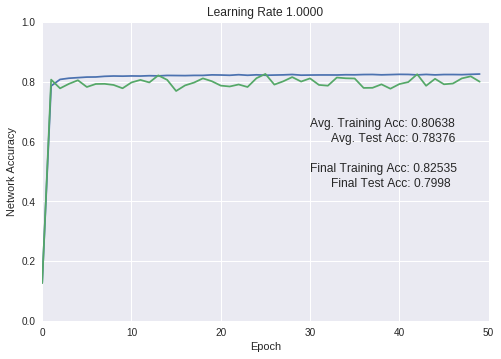

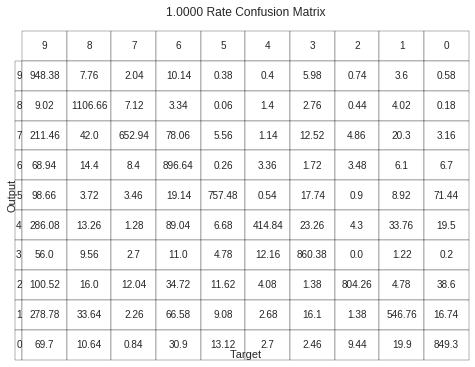

In [0]:
network1.plot()

This network shows signs of overfitting the data. The test accuracy is consistently less than the training accuracy. However, the test accuracy occasionally overcomes the training data due to the high amplitude of its oscillations. 

This network reliably fails to identify the numeral 9 and often mistakes it for a 4 or a 7.

### 0.1 Learning Rate

In [0]:
network2 = Network(0.1, dataset)
network2.run()

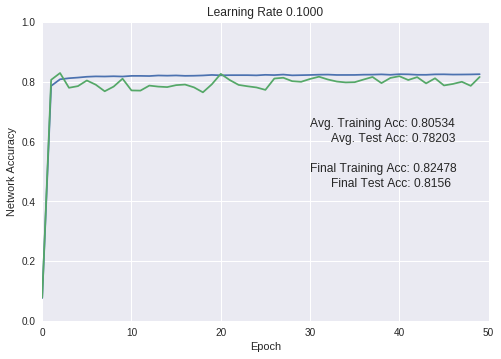

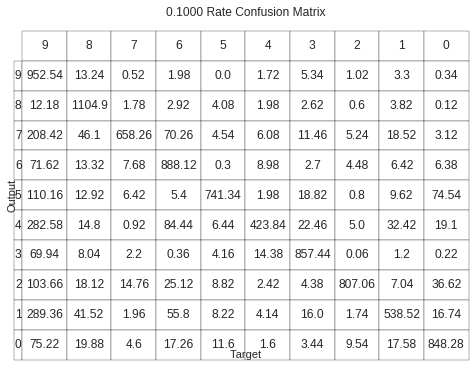

In [0]:
network2.plot()

This network also shows signs of overfitting, with the average test accuracy falling below the training accuracy for most epochs. Compared to the network with a learning rate of 1, the oscillations seem about the same magnitude at this graph scale. However, around the 25th epoch, the testing accuracy jumps up, and the future epochs maintain the height. The previous network seemed to fluctuate around the same mean for all epochs.

The network shares the same weakpoint at identifying 9's.

### 0.01 Learning Rate

In [0]:
network3 = Network(0.01, dataset)
network3.run()

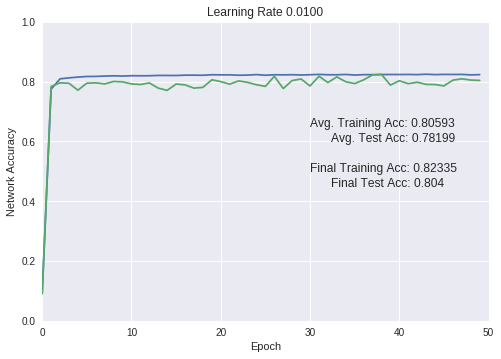

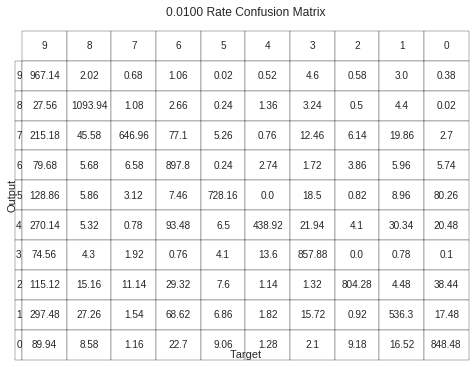

In [0]:
network3.plot()

Compared to the previous networks, this amplitude of its oscillations is much lower. The slopes towards peaks in accuracy are much smaller and an average trend line is more apparent.

### 0.001 Learning Rate

In [0]:
network4 = Network(0.001, dataset)
network4.run()

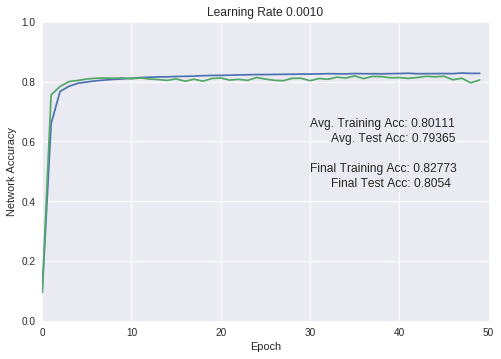

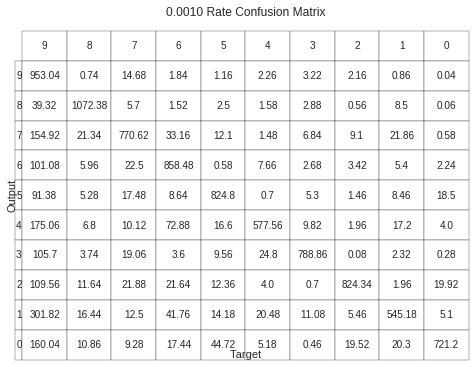

In [0]:
network4.plot()

Not only does this network have a smaller amplitude in its oscillations when compared to the previous networks, but it also has a higher average testing accuracy. Overfitting is less of an issue, with the average training accuracy less than a percent higher than the testing.

Unfortunately, this network still has issues discriminating the numeral 9, most often confusing them for 1's

###0.0001 Learning Rate

In [0]:
network5 = Network(0.0001, dataset)
network5.run()

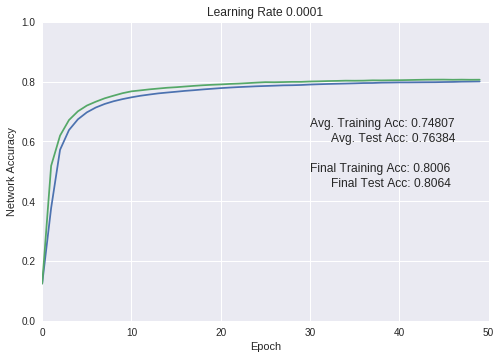

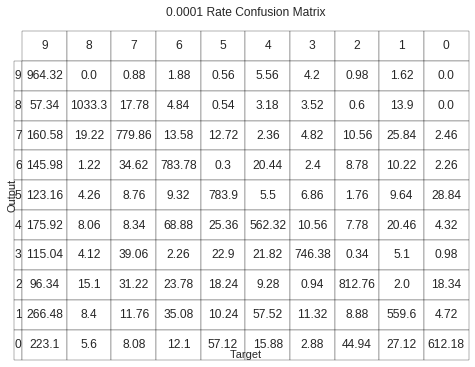

In [0]:
network5.plot()

This network shows no oscillations at this graph scale and has a much lower accuracy than the other networks. However, it does have the benefit of lacking overfitting. The testing accuracy is higher than the training accuracy for every epoch. I assume this is due to testing occuring after the network has trained through an epoch, so the network has already minimized the error of the output before testing is done.

There still exists a classifying error when encountering 9's.

##Conclusion

After training each network with the dataset and reviewing their results the effect of the learning rate on a network's accuracy is apparent.

By increasing the learning rate, the amplitude of oscillations in testing accuracy increase. This can lead to large movements in the network's approximation. Occasionally these oscillations put the testing accuracy above the training, but in most cases the testing accuracy falls well below.

By decreasing the learning rate, the amplitude of oscillations decreases as well, leading to smaller changes in the network's approximation. This results in requiring more training to reach acceptable levels of accuracy, but also does not lead to extreme overfitting.

Each network encountered difficulty when attempting to discriminate 9's from the other numerals, most often 1, 7, and 4. I hypothesize that this is due to handwritten 9's containing similar features to the other numerals. However, it could also be due to my implementation of the activation for outputs. Perhaps if the network identified its maximum output before activation flattened them to one or two, there would be less of an issue recognizing 9.

From the results I would most likely use a network with a lower learning rate such as 0.001 in order to avoid significant overfitting. However, if time is not a factor, I might experiment with using a lower learning rate such as 0.0001 at a higher epoch, to see if the accuracy reaches higher with miniscule or no overfitting.